In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import json

plt.style.use('../peptidome.mplstyle')

import sys
sys.path.append('..')
from lib import *

In [2]:
class memoized(object):
    """Decorator. Caches a function's return value each time it is called.
    If called later with the same arguments, the cached value is returned
    (not reevaluated).
    """
    def __init__(self, func):
        self.func = func
        self.cache = {}

    def __call__(self, *args):
        # if args is not Hashable we can't cache
        # easier to ask for forgiveness than permission
        try:
            if args in self.cache:
                return self.cache[args]
            else:
                value = self.func(*args)
                self.cache[args] = value
                return value
        except TypeError:
            return self.func(*args)

In [3]:
from subprocess import check_output
from io import StringIO
@memoized
def normalize_taxid(taxid, rank='species'):
    'return species level taxon id'
    if not taxid:
        return ''
    out = check_output('efetch -db taxonomy -id "{taxid}"  -format native -mode xml -json'.format(taxid=taxid), shell=True, text=True)
    buffer = StringIO(out)
    results = json.load(buffer)
    if results['TaxaSet']['Taxon']['Rank'] == 'species':
        print(taxid, 'is species')
        return taxid
    try:
        print(taxid, len(results['TaxaSet']['Taxon']['LineageEx']['Taxon']))
        ids = [level['TaxId'] for level in results['TaxaSet']['Taxon']['LineageEx']['Taxon'] if level['Rank'] == rank]
    except (KeyError, TypeError):
        return ''
    if len(ids) == 0:
        return ''
    return ids[0] 

In [4]:
df = load_unirefproteome_as_df_path(datadir + 'human-viruses-uniref90.fasta')
df['length'] = df['Sequence'].str.len()
df.sort_values('length', ascending=False, inplace=True)
df = df[~df['header'].str.contains('(Fragment)')]

/home/amayer/anaconda3/envs/py3/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [5]:
df['TaxID_species'] = df['TaxID'].apply(normalize_taxid)

11118 7
290028 is species
694003 is species
2697049 12
2509481 10
11137 is species
277944 is species
1980521 is species
1980519 is species
10310 is species
11051 7
11079 is species
11082 is species
11072 is species
64315 9
59563 is species
64320 is species
11083 is species
44024 is species
11089 is species
164416 is species
38837 is species
12637 is species
10325 is species
340907 is species
10376 is species
10298 is species
10294 8
11103 is species
11108 11
10335 is species
37296 is species
11034 is species
2169701 is species
11036 is species
11019 7
11029 is species
37124 is species
1554474 10
59300 is species
59301 is species
194960 7
11033 is species
11020 is species
688449 7
11269 is species
12103 7
12104 9
204711 9
95341 7
11572 8
1979160 is species
39744 9
11158 7
121791 is species
63330 is species
10359 is species
11620 is species
138950 is species
12059 7
186539 is species
2169992 is species
186538 is species
2169991 is species
11623 is species
186540 is species
11628 is speci

In [6]:
def parse_protein_name(header):
    m = re.search('(?<=\s).+(?=\sn\=)', header)
    if m:
         return m.group(0)
    return ''

In [7]:
df['Protein name'] = df.apply(lambda row: parse_protein_name(row['header']), axis=1)

In [8]:
df['TaxID_species'].value_counts().head(20)

11676     40480
           2139
10407      2038
10310       895
10298       812
10359       787
11709       381
337041      352
11082       302
10243       284
10258       275
12475       257
10279       218
10376       206
10255       142
10245       141
37296       140
10325       131
99000       117
38804       106
Name: TaxID_species, dtype: int64

In [9]:
df = df[~(df['TaxID_species']=='')]

In [10]:
len(set(df['TaxID'].unique())), len(set(df['TaxID_species'].unique()))

(377, 173)

(array([45., 53., 35., 14., 13.,  8.,  3.,  1.,  0.,  1.]),
 array([0.        , 0.46072405, 0.9214481 , 1.38217215, 1.8428962 ,
        2.30362025, 2.7643443 , 3.22506835, 3.6857924 , 4.14651645,
        4.6072405 ]),
 <BarContainer object of 10 artists>)

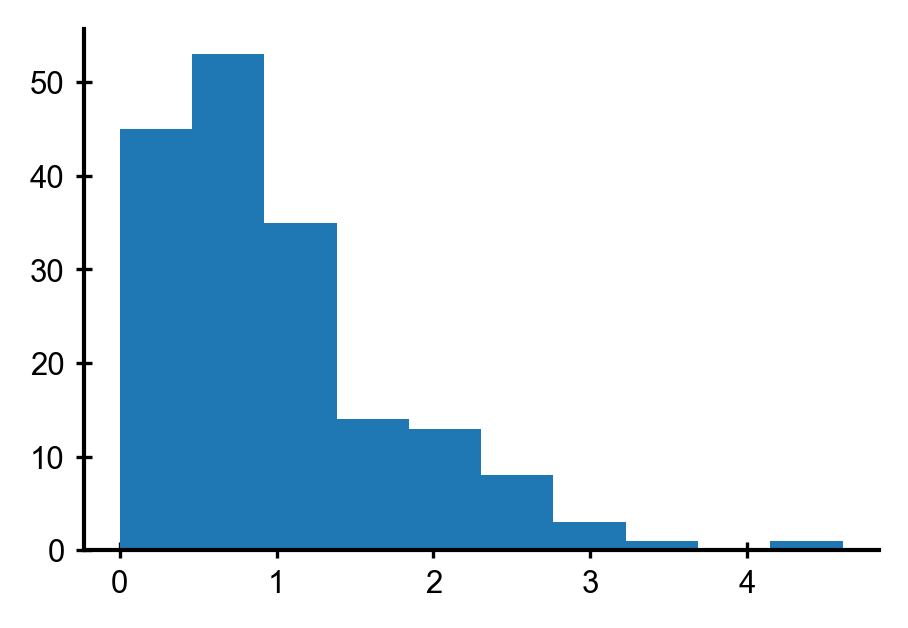

In [11]:
plt.hist(np.log10(df['TaxID_species'].value_counts()))

In [12]:
def counter_to_series(counter):
    count_df = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
    count_series = count_df.T.squeeze()
    return count_series
def fraction_multiple(series):
    return np.sum(series[series>1])/np.sum(series)

In [13]:
k = 9
filterlength = 12

In [14]:
count_series = counter_to_series(count_kmers_iterable(df['Sequence'], k, clean=True))
fraction_multiple(count_series)

0.8895016414165472

In [15]:
filtered = df.groupby('TaxID_species').head(500)
#filtered = df.groupby(['TaxID_species', 'Protein name']).head(1)

In [16]:
#write_fasta(filtered, datadir+'human-viruses-uniref90-filtered.fasta',
#            seqcolumn='Sequence', descriptioncolumn='header')

In [16]:
count_series_filtered = counter_to_series(count_kmers_iterable(filtered['Sequence'], k, clean=True))
fraction_multiple(count_series_filtered)

0.7218258421928375

In [18]:
count_series_filtered_unique = counter_to_series(
                       count_kmers_iterable(
                           filter_unique(filtered['Sequence'], k, filterlength),
                           k)
                       )
fraction_multiple(count_series_filtered_unique)

0.052805935515388376

In [19]:
'all %e, filtered %e, unique %e'%(np.sum(df['Sequence'].str.len()),
              np.sum(filtered['Sequence'].str.len()),
              np.sum(count_series_filtered_unique))

'all 2.168479e+07, filtered 1.275921e+06, unique 9.825600e+05'

In [20]:
count_series_filtered_unique.sort_values().tail(10)

CWYGMEIRP     8
SSSSSSSSS     8
GCWYGMEIR     8
DDDDDDDDD     9
WTSLNFLGG     9
DTAGWDTRI     9
TAGWDTRIT     9
GGGGGGGGG    10
KKKKKKKKK    10
PPPPPPPPP    13
Name: count, dtype: int64

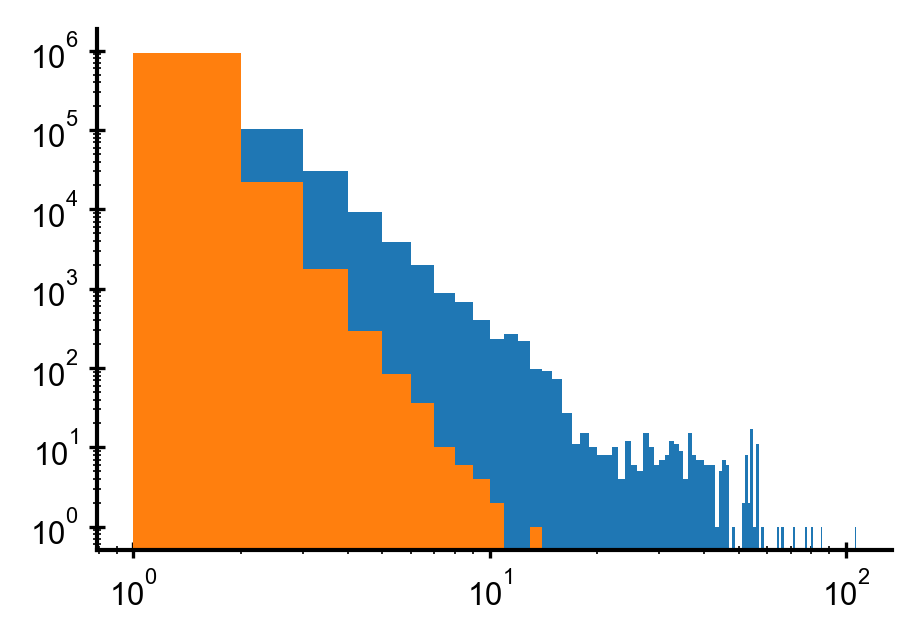

In [21]:
counts, bins, _ = plt.hist(count_series_filtered, log=True,
                           bins=np.arange(0, count_series_filtered.max()+1, 1+count_series_filtered.max()//1000));
plt.hist(count_series_filtered_unique, log=True, bins=bins);
plt.xscale('log')